# Ajustando modelos

## Dividindo os dados entre treino e teste

Para compreender se o modelo está de fato aprendendo com os dados, precisamos fazer uma separação dos dados entre treinamento e teste. Os dados de **treinamento** são usados para ajustar o modelo, enquanto os dados de **teste** servem para verificar o aprendizado do modelo em dados que não foram utilizados no momento do ajuste.

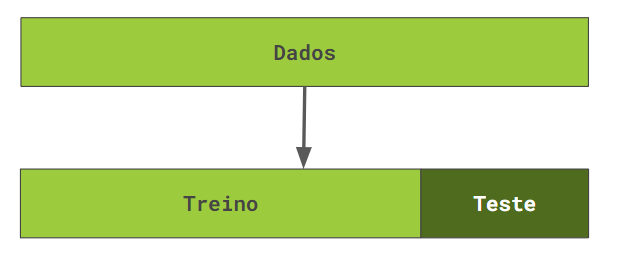

Aplicando a codificação da aula anterior...

In [1]:
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# splitting data
data = pd.read_csv('./marketing_investimento.csv')
target = 'aderencia_investimento'
x = data.drop(target, axis=1)
y = data[target] 

# transformer
categorical_cols = ['estado_civil', 'escolaridade', 'inadimplencia', 'fez_emprestimo']
one_hot = make_column_transformer(
    (
        OneHotEncoder(drop='if_binary'),
        categorical_cols
    ),
    remainder='passthrough',
    sparse_threshold=0
)

# encoding x
cols = x.columns
x = one_hot.fit_transform(x)
x = pd.DataFrame(x, columns=one_hot.get_feature_names_out(cols))

# encoding y
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [2]:
x.head()

,onehotencoder__estado_civil_casado (a),onehotencoder__estado_civil_divorciado (a),onehotencoder__estado_civil_solteiro (a),onehotencoder__escolaridade_fundamental,onehotencoder__escolaridade_medio,onehotencoder__escolaridade_superior,onehotencoder__inadimplencia_sim,onehotencoder__fez_emprestimo_sim,remainder__idade,remainder__saldo,remainder__tempo_ult_contato,remainder__numero_contatos
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,45.0,242.0,587.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,42.0,1289.0,250.0,4.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,23.0,363.0,16.0,18.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,58.0,1382.0,700.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50.0,3357.0,239.0,4.0


In [3]:
y

array([1, 1, 0, ..., 1, 1, 1])

Fazendo a divisão dos dados entre treino e teste, utilizando a função `train_test_split`

In [4]:
from sklearn.model_selection import train_test_split

A função retorna os dados já separados em subconjuntos (x - treino e teste, e y - treino e teste), então podemos armazená-los em variáveis específicas. 

Por padrão, a função separa 75% dos dados para treino e 25% para teste. Esses valores podem ser alterados via parâmetros.

O parâmetro `stratify` possibilita informar uma variável para decidir a proporção de dados para treino e teste, baseados na variável informada. Assim, a função tentará manter uma proporção igual de classes da variável informada, tanto em treino quanto em teste. Por exemplo, a coluna `aderencia_investimento` possui 502 entradas "sim" e 766 entradas "nao" (proporção de 0.65). Passando esta coluna para `stratify` fará com que train_test_split separe um valor proporcional de entradas "sim" e "nao" tanto para treino quanto para teste, para não haver um desbalanceamento.

O parâmetro `random_state` seria como um "seed", em que a gente informa um valor para que o retorno da função seja sempre o mesmo (é usado para acompanhar a mesma saída que o instrutor tem na aula; em produção não tem tanto sentido).

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=5)

In [6]:
print(x_train.shape)
print(x_test.shape)
print(len(y_train))
print(len(y_test))

(951, 12)
(317, 12)
951
317


Conferindo se stratify manteve uma proporção das categorias de y:

In [7]:
import numpy as np

print('=== With stratify ===')
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x, y, random_state=5)

print('=== Without stratify ===')
print(np.unique(y_train_2, return_counts=True))
print(np.unique(y_test_2, return_counts=True))

=== With stratify ===
(array([0, 1]), array([575, 376], dtype=int64))
(array([0, 1]), array([191, 126], dtype=int64))
=== Without stratify ===
(array([0, 1]), array([571, 380], dtype=int64))
(array([0, 1]), array([195, 122], dtype=int64))


Quando usado o stratify, a proporção foi de 0,6539 no treino e 0,6597 no teste. Se não usar o stratify, a proporção fica 0,6655 e 0,6597. A proporção em y é de 0,6554.

## Modelo de base

O modelo mais simples de classificar os dados é simplesmente utilizar um algoritmo que chuta todas as classificações para a classe que tem maior frequência. Esse algoritmo serve como um **critério de comparação**, para identificar se os outros modelos tem um desempenho melhor do que a classificação mais simples possível.

Os modelos costumam ter um método `fit`, que é o que chamamos para treinar o modelo. Geralmente também é oferecido o método `score`, que fornece alguma métrica para verificar o desempenho do modelo treinado, quando dados de teste são passados a ele.

O `DummyClassifier` possibilita fazer essa classificação simples, baseada na classe mais frequente (essa estratégia pode ser modificada via parâmetro). Seu método `score` retorna a acurácia (proporção de vezes que o modelo acertou).

In [8]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()

# training the model with the train data
dummy.fit(x_train, y_train)

# checking the accuracy score
dummy.score(x_test, y_test)

0.6025236593059937

## Árvore de decisão

O modelo de árvore de decisão é muito utilizado pela sua alta **explicabilidade** e **processamento rápido**, mantendo um desempenho bem interessante.

Ele se baseia em decisões simples tomadas pelo algoritmo, separando os dados com base em comparações de **menor** e **maior** nos valores das colunas da base de dados. Alguns algoritmos fazem a separação em mais de um subconjunto de dados, enquanto outros fazem a separação em somente dois subconjuntos (divisão binária). No caso da `DecisionTreeClassifier` que iremos utilizar, é aplicada a divisão binária a cada nível de profundidade da árvore.

In [9]:
from sklearn.tree import DecisionTreeClassifier

# initialize the model
tree = DecisionTreeClassifier(random_state=5)

# train the model
tree.fit(x_train, y_train)

DecisionTreeClassifier(random_state=5)

Outro método comum em modelos é o `predict`, que retorna a classificação que o modelo dá para os valores de entrada passados por parâmetro. Podemos utilizá-lo para ver a saída que será dada a cada dado de teste.

In [10]:
tree.predict(x_test)

array([0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,

Verificando o score:

In [11]:
tree.score(x_test, y_test)

0.6656151419558359

O score é melhor que o obtido com o `DummyClassifier`. 

O sklearn também possibilita verificarmos graficamente a árvore de decisão criada pelo modelo, por meio da função `plot_tree`. Essa função retorna um plot, que pode ser ajustado por meio da matplotlib.

In [12]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

Vamos passar ao `plot_tree` um nome simplificado para as colunas do dataset (o transformer criou colunas com nomes muito longos). Isso é feito no parâmetro `feature_names`.

In [13]:
nome_colunas = [
    'casado (a)',
    'divorciado (a)',
    'solteiro (a)',
    'fundamental',
    'medio',
    'superior',
    'inadimplencia',
    'fez_emprestimo',
    'idade',
    'saldo',
    'tempo_ult_contato',
    'numero_contatos'
]

O parâmetro `filled` irá aplicar uma cor diferente para cada nó da árvore, de acordo com sua classificação na variável alvo (a classe mais frequente naquele nó).

O parâmetro `class_names` permite passar um nome para cada classe (por conta do `LabelEncoder`, as classes são [0, 1]).

Colocar o ponto e vírgula (`;`) no final da função omite uma série de textos que a função plot_tree imprime, mostrando somente o plot.

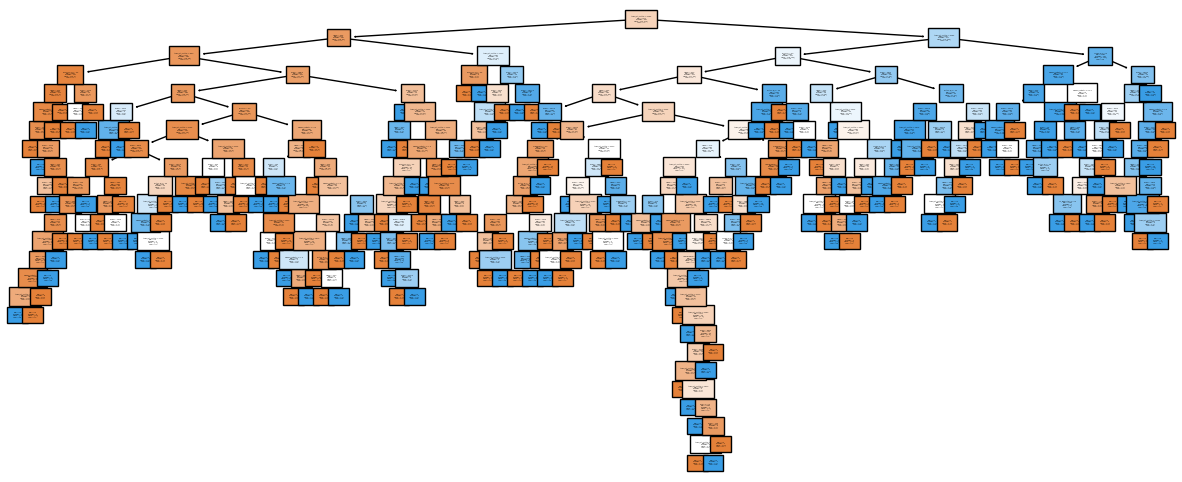

In [14]:
plt.figure(figsize=(15, 6))
plot_tree(tree, filled=True, class_names=['nao', 'sim'], fontsize=1, feature_names=nome_colunas);

É possível visualizar que a árvore final é cheia de decisões e bem profunda. Isso pode indicar que talvez haja **overfitting** do modelo. Isso pode ser verificado ao avaliar o score utilizando os dados de treinamento:

In [15]:
tree.score(x_train, y_train)

1.0

O score foi de 1.0 (100%). Isso também indica um overfitting. O que pode ser feito neste caso é uma "poda" na árvore, marcando uma profundidade máxima que ela pode usar. Isso possibilita criar um modelo mais genérico, que não se ajuste fielmente somente aos dados passados no treinamento. 

Para isso, usamos o parâmetro `max_depth`.

In [16]:
tree = DecisionTreeClassifier(random_state=5, max_depth=3)
tree.fit(x_train, y_train)
tree.score(x_train, y_train)

0.7613038906414301

O desempenho do modelo, utilizando os próprios dados de treino, agora não é mais de 100%. Mas ainda assim, o score é alto. Vamos verificar como o modelo se sai com novos dados.

In [17]:
tree.score(x_test, y_test)

0.7160883280757098

É possível observar que o score também foi mais alto no teste, o que indica que o modelo "podado" ficou mais genérico e obteve um desempenho melhor do que o anterior. 

Visualizando a árvore criada pelo modelo:

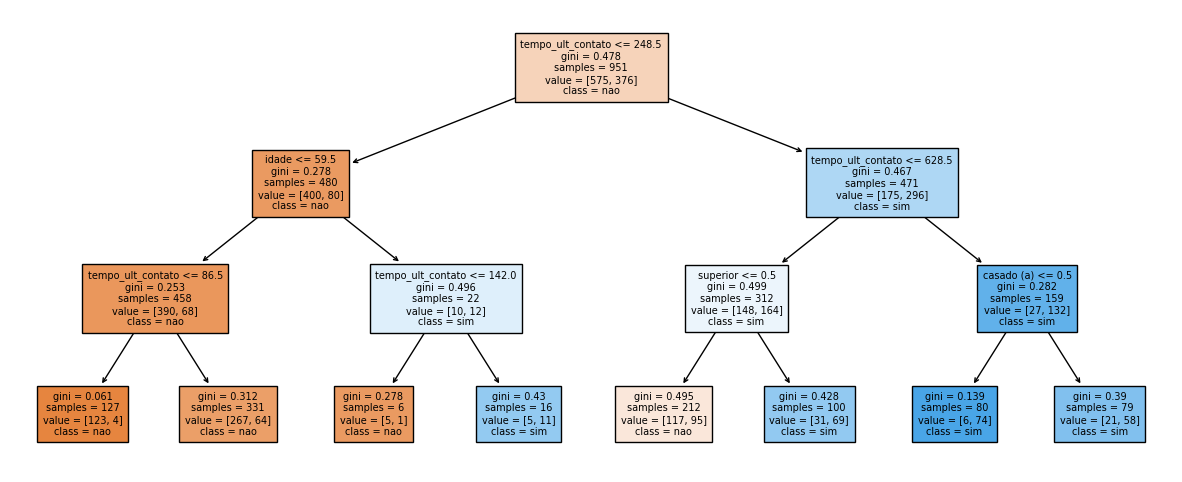

In [18]:
plt.figure(figsize=(15, 6))
plot_tree(tree, filled=True, class_names=['nao', 'sim'], fontsize=7, feature_names=nome_colunas);